# Лабораторная работа №3 “Переобучение и регуляризация”

### *Набор данных **ex3data1.mat** представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит две переменные X (изменения уровня воды) и y (объем воды, вытекающий из дамбы). По переменной X необходимо предсказать y. Данные разделены на три выборки: обучающая выборка (X, y), по которой определяются параметры модели; валидационная выборка (Xval, yval), на которой настраивается коэффициент регуляризации; контрольная выборка (Xtest, ytest), на которой оценивается качество построенной модели.*

## **Задание**

### 1. Загрузите данные **ex3data1.mat** из файла.

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import io

from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [3]:
ex3data1 = io.loadmat('Data/Lab 3/ex3data1.mat')

Xtrain, ytrain = ex3data1['X'], ex3data1['y'].flatten()
Xval, yval = ex3data1['Xval'], ex3data1['yval'].flatten()
Xtest, ytest = ex3data1['Xtest'], ex3data1['ytest'].flatten()

### 2. Постройте график, где по осям откладываются X и y из обучающей выборки.

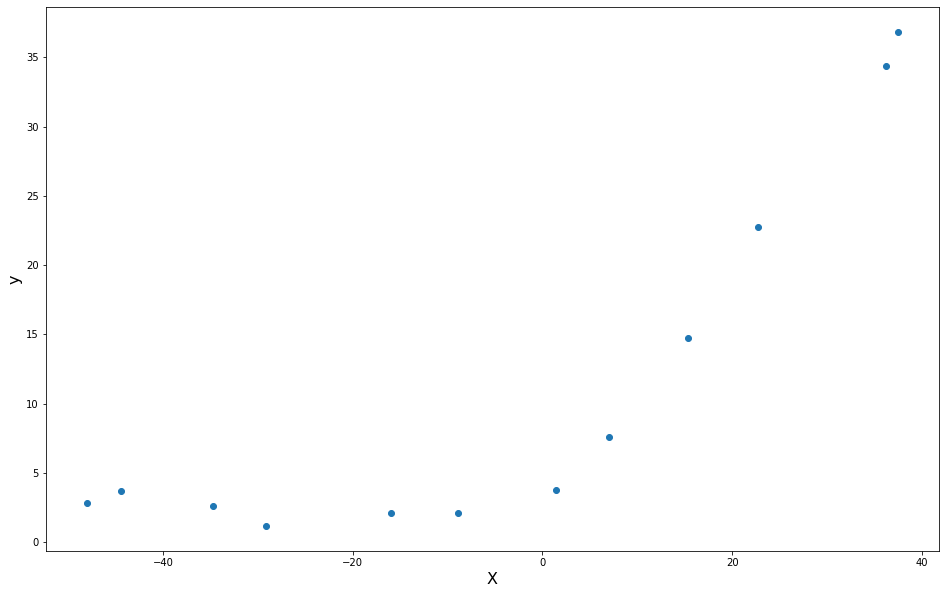

In [4]:
plt.figure(figsize=(16, 10))
plt.scatter(Xtrain, ytrain, cmap='viridis')
plt.xlabel('X', size=16)
plt.ylabel('y', size=16)
plt.show()

### 3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.

In [5]:
class LinearRegression:
    
    def __init__(self, dim):
        self.dim = dim + 1
        self.w = np.zeros(dim + 1)
    
    @property
    def weights(self):
        return self.w[:-1]
    
    @property
    def bias(self):
        return self.w[-1]
    
    def __repr__(self):
        return str(self.w)
    
    def __call__(self, x):
        value = np.dot(x, self.weights) + self.bias
        return float(value)
    
    def grad(self, x):
        return np.array(list(x) + [1])
    

class MSELoss:
    def __init__(self, model, reg_lambda):
        self.model = model
        self.reg_lambda = reg_lambda

    def __call__(self, x, y):
        pred = np.array([self.model(x_i) for x_i in x])
        return np.mean((pred - y) ** 2) + self.reg_lambda * np.sum(self.model.weights ** 2)
    
    def grad(self, x, y):
        preds = np.array([self.model(x_i) for x_i in x])
        grads = np.array([self.model.grad(x_i) for x_i in x])
    
        errors = np.expand_dims(preds - y, axis=1)
        # No regularization for bias
        reg_term = 2. * self.reg_lambda * np.array(self.model.weights.tolist() + [0])

        return np.mean(2 * grads * errors, axis=0) + reg_term

### 4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.

In [8]:
def get_gradient_descent(loss, alpha, eps, validation=None):
    def apply(X, y):
        iter_num = 0
        need_stop = False
        
        initial_loss = loss_before = loss_after = loss(X, y)

        loss_steps = {'train': [], 'val': []}
        loss_steps['train'].append(loss(X, y))
        if validation is not None:
            X_val, y_val = validation
            loss_steps['val'].append(loss(X_val, y_val))
        
        while not need_stop:
            model_grad = loss.grad(X, y)  
            assert model_grad.shape == loss.model.w.shape
            
            loss.model.w -= alpha * model_grad
            loss_after = loss(X, y)
            assert loss_before >= loss_after
            
            need_stop = loss_before - loss_after <= eps
            
            loss_before = loss_after

            loss_steps['train'].append(loss(X, y))
            if validation is not None:
                X_val, y_val = validation
                loss_steps['val'].append(loss(X_val, y_val))
                
            iter_num += 1
        
        return {
            'initial_loss': initial_loss,
            'loss_after': loss_after,
            'loss_steps': loss_steps,
            'model': loss.model,
            'iter_num': iter_num
        }
    
    return apply

### 5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта 2. Почему регуляризация в данном случае не сработает?

In [9]:
model = LinearRegression(dim=1)
loss = MSELoss(model, reg_lambda=0.)

In [10]:
gradient_descent = get_gradient_descent(loss, alpha=0.001, eps=1e-6)
result = gradient_descent(Xtrain, ytrain)

trained_model = result['model']

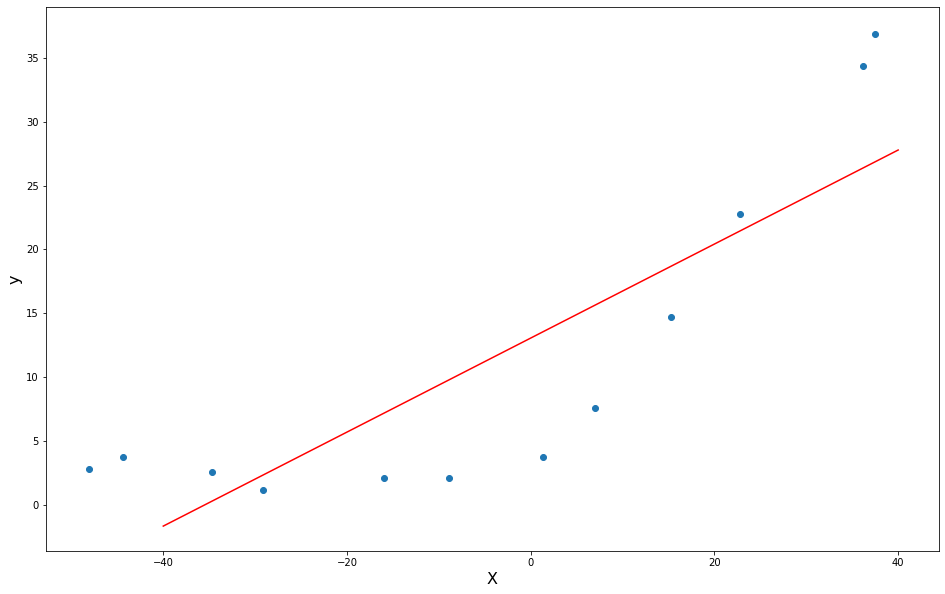

In [11]:
X_linspace = np.expand_dims(np.linspace(-40, 40, 100), axis=1)
y_linspace = np.array([trained_model(x_i) for x_i in X_linspace])

plt.figure(figsize=(16, 10))

plt.plot(X_linspace.flatten(), y_linspace, color='r')

plt.scatter(Xtrain, ytrain, cmap='viridis')

plt.xlabel('X', size=16)
plt.ylabel('y', size=16)
plt.show()

Регуляризация не работает, так как из-за лямбда равного нулю занулится слагаемое, которое отвечает за регуляризацию и в лоссе и в градиенте, соответственно.

### 6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?

In [16]:
model = LinearRegression(dim=1)
loss = MSELoss(model, reg_lambda=0.)

gradient_descent = get_gradient_descent(loss, alpha=0.001, eps=1e-6, validation=(Xval, yval))
result = gradient_descent(Xtrain, ytrain)

train_curve = result['loss_steps']['train']
val_curve = result['loss_steps']['val']

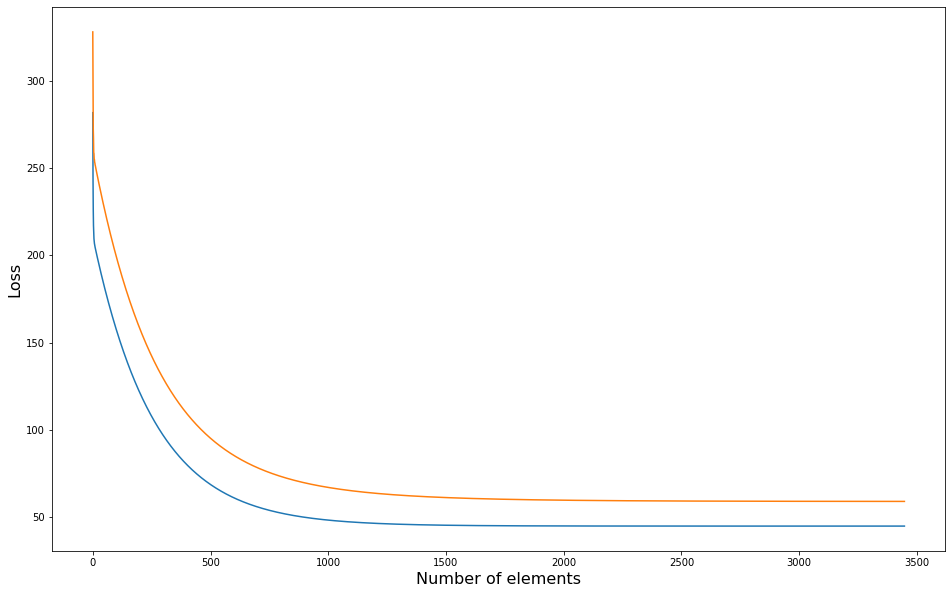

In [18]:
plt.figure(figsize=(16, 10))

plt.plot(train_curve)
plt.plot(val_curve)

plt.ylabel('Loss', size=16)
plt.xlabel('Number of elements', size=16)
plt.show()

Мы видим, что лосс у модели достаточно велик. Это объясняется тем, что мы пытаемся приблизить линейной функцией нелинейную зависимость. Также модель  немного переобучена.

### 7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X<sup>2</sup>, X<sup>3</sup>, X<sup>4</sup>, …, X<sup>p</sup>).

In [22]:
def add_polynomial_features(X, p):
    polynomial_transform = PolynomialFeatures(degree=p)
    return polynomial_transform.fit_transform(X)

### 8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.

In [21]:
X_train_norm = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)
X_val_norm = (Xval - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)
X_test_norm = (Xtest - Xtrain.mean(axis=0)) / Xtrain.std(axis=0)

### 9. Обучите модель с коэффициентом регуляризации 0 и p = 8.

In [23]:
X_train_new = add_polynomial_features(X_train_norm, p=8)
X_val_new = add_polynomial_features(X_val_norm, p=8)

def train_model_with_regularization(train, val, reg_lambda):
    X_train, y_train = train
    model = LinearRegression(dim=X_train.shape[1])
    loss = MSELoss(model, reg_lambda)

    gradient_descent = get_gradient_descent(loss, alpha=0.001, eps=1e-3, validation=val)
    return gradient_descent(X_train, y_train)
    
result_0 = train_model_with_regularization((X_train_new, ytrain), (X_val_new, yval), reg_lambda=0.)
result_0['model']

[ 2.3979646   5.3533757   3.44534834  3.37967537  2.62010226  1.59080736
  1.42033116 -0.88809698 -0.88220668  2.3979646 ]

### 10. Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?

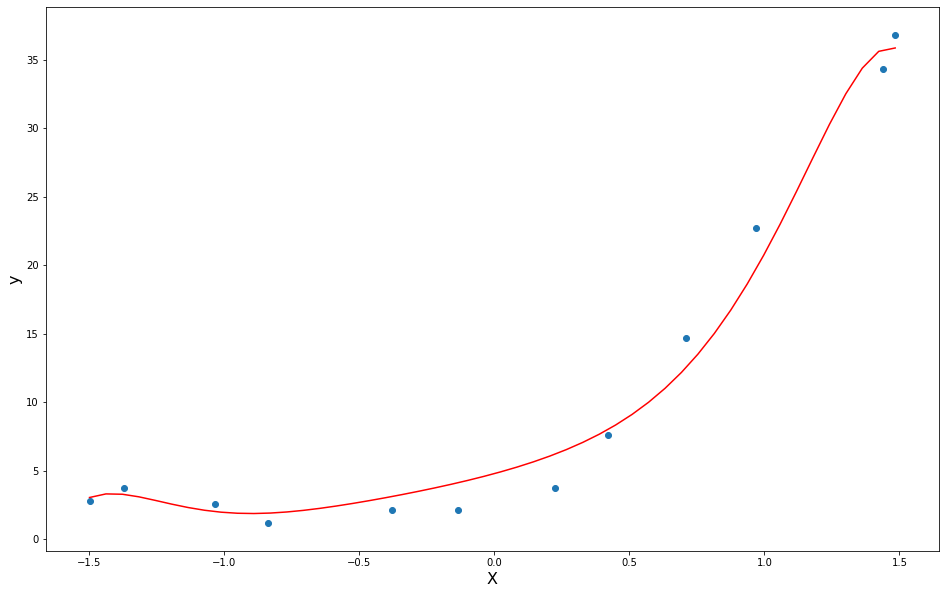

In [29]:
trained_model = result_0['model']

X_linspace = np.expand_dims(np.linspace(np.min(X_train_norm), np.max(X_train_norm), 50), axis=1)
X_linspace_new = add_polynomial_features(X_linspace, p=8)

y_linspace = np.array([trained_model(x_i) for x_i in X_linspace_new])

plt.figure(figsize=(16, 10))

plt.plot(X_linspace.flatten(), y_linspace, color='r')

plt.scatter(X_train_norm, ytrain, cmap='viridis')

plt.xlabel('X', size=16)
plt.ylabel('y', size=16)
plt.show()

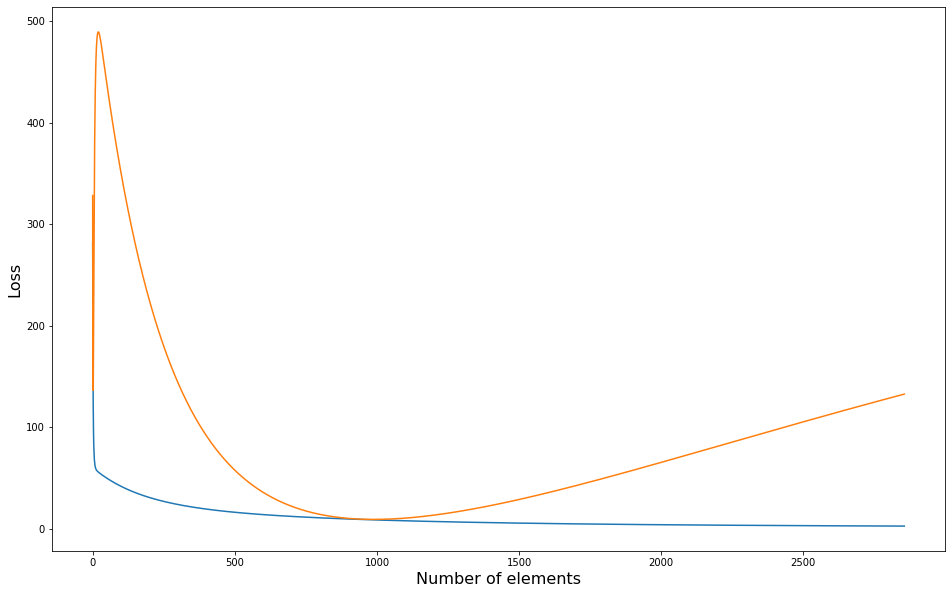

In [28]:
train_curve = result_0['loss_steps']['train']
val_curve = result_0['loss_steps']['val']

plt.figure(figsize=(16, 10))

plt.plot(train_curve)
plt.plot(val_curve)

plt.ylabel('Loss', size=16)
plt.xlabel('Number of elements', size=16)
plt.show()

Мы видим, что наша модель хорошо описывает данные тренировочной выборки, а также значительно уменьшился лосс в сравнении с предыдущим пунктом (за счет добавления нелинейности), однако модель сильно переобучилась.

### 11. Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?

In [30]:
result_1 = train_model_with_regularization((X_train_new, ytrain), (X_val_new, yval), reg_lambda=1.)
result_100 = train_model_with_regularization((X_train_new, ytrain), (X_val_new, yval), reg_lambda=100.)

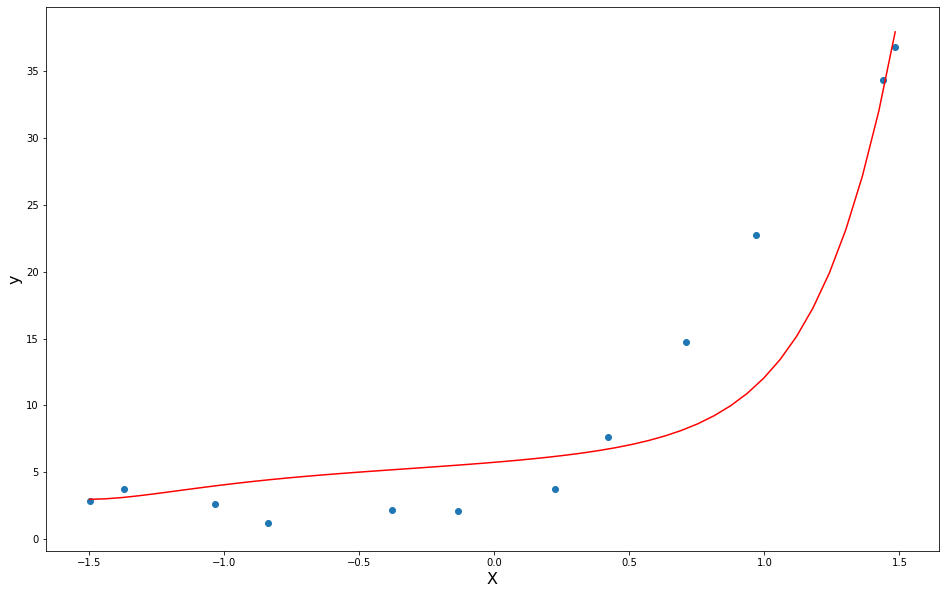

In [31]:
trained_model = result_1['model']

X_linspace = np.expand_dims(np.linspace(np.min(X_train_norm), np.max(X_train_norm), 50), axis=1)
X_linspace_new = add_polynomial_features(X_linspace, p=8)

y_linspace = np.array([trained_model(x_i) for x_i in X_linspace_new])

plt.figure(figsize=(16, 10))

plt.plot(X_linspace.flatten(), y_linspace, color='r')

plt.scatter(X_train_norm, ytrain, cmap='viridis')

plt.xlabel('X', size=16)
plt.ylabel('y', size=16)
plt.show()

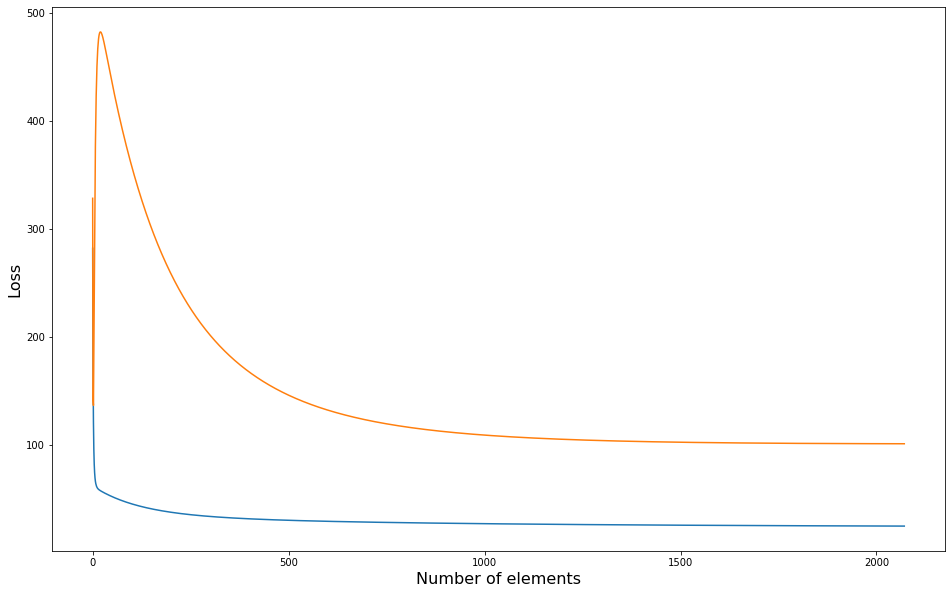

In [33]:
train_curve = result_1['loss_steps']['train']
val_curve = result_1['loss_steps']['val']

plt.figure(figsize=(16, 10))

plt.plot(train_curve)
plt.plot(val_curve)

plt.ylabel('Loss', size=16)
plt.xlabel('Number of elements', size=16)
plt.show()

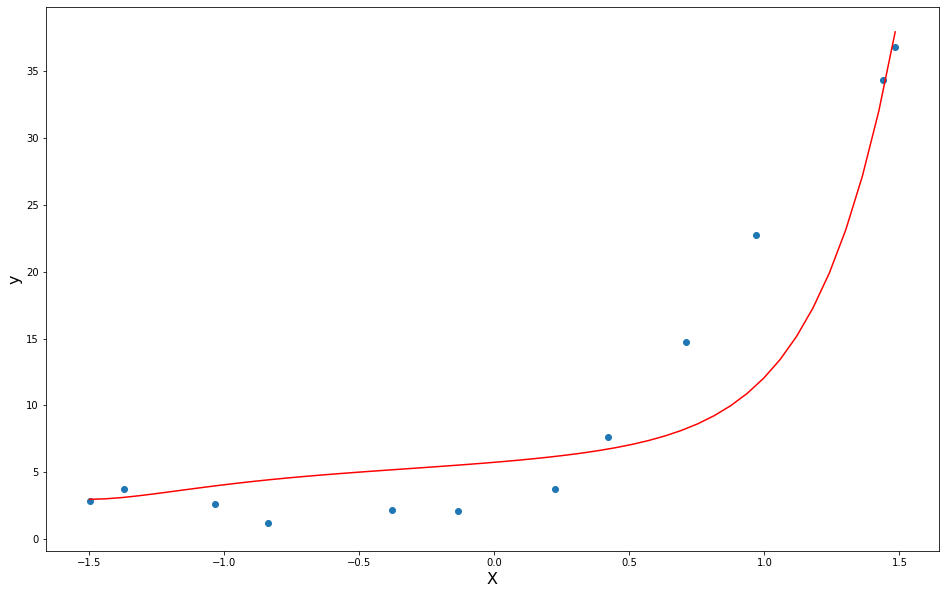

In [34]:
trained_model = result_1['model']

X_linspace = np.expand_dims(np.linspace(np.min(X_train_norm), np.max(X_train_norm), 50), axis=1)
X_linspace_new = add_polynomial_features(X_linspace, p=8)

y_linspace = np.array([trained_model(x_i) for x_i in X_linspace_new])

plt.figure(figsize=(16, 10))

plt.plot(X_linspace.flatten(), y_linspace, color='r')

plt.scatter(X_train_norm, ytrain, cmap='viridis')

plt.xlabel('X', size=16)
plt.ylabel('y', size=16)
plt.show()

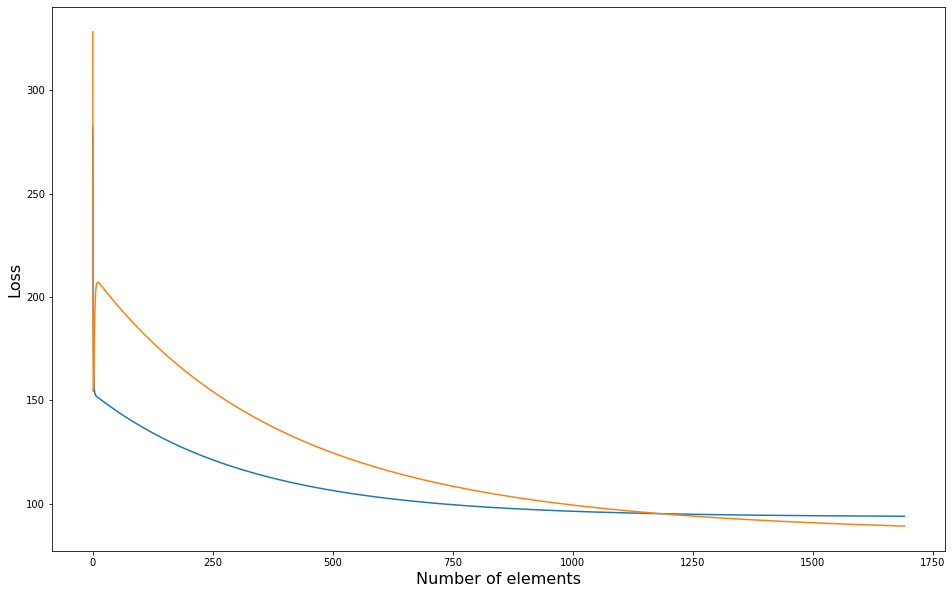

In [32]:
train_curve = result_100['loss_steps']['train']
val_curve = result_100['loss_steps']['val']

plt.figure(figsize=(16, 10))

plt.plot(train_curve)
plt.plot(val_curve)

plt.ylabel('Loss', size=16)
plt.xlabel('Number of elements', size=16)
plt.show()

Из графиков можно сделать вывод, что регуляризация действительно помогает модели не переобучиться, но если параметр регуляризации выбирать достаточно высоким, то модель очень плохо запоминает зависимости в исходных данных.

### 12. С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).

In [35]:
reg_lambda_range = np.arange(0., 5., 0.1)
val_loss_values = []

for reg_lambda in reg_lambda_range:
    result = train_model_with_regularization((X_train_new, ytrain), val=None, reg_lambda=reg_lambda)
    trained_model = result['model']

    val_loss = MSELoss(trained_model, reg_lambda=0)
    val_loss_values.append(val_loss(X_val_new, yval))

In [38]:
optimal_reg_lambda = reg_lambda_range[np.argmin(val_loss_values)]
optimal_reg_lambda

0.2

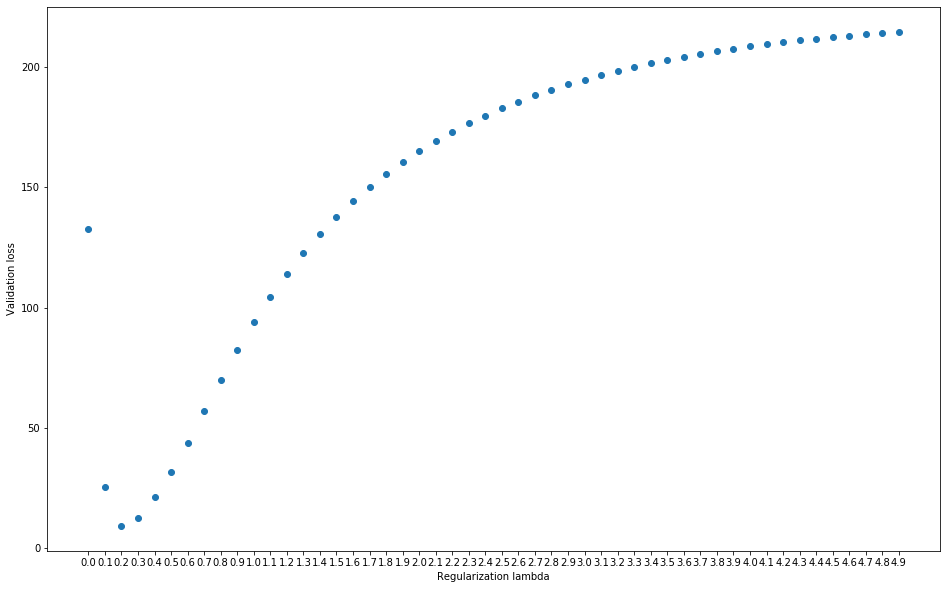

In [37]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(reg_lambda_range, val_loss_values, cmap='viridis')
plt.xticks(reg_lambda_range)

plt.xlabel('Regularization lambda')
plt.ylabel('Validation loss')
plt.show()

### 13. Вычислите ошибку (потерю) на контрольной выборке.

In [39]:
best_result = train_model_with_regularization((X_train_new, ytrain), val=None, reg_lambda=optimal_reg_lambda)
best_model = best_result['model']

X_test_new = add_polynomial_features(X_test_norm, p=8)

test_loss = MSELoss(best_model, reg_lambda=0)
test_loss(X_test_new, ytest)

10.660894037084278